### Imports

In [6]:
from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import tensorflow
import os 
from PIL import Image
import glob

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import preprocess_input

### Loading the data

In [29]:
train_directory = r"../raw_data/train"

In [30]:
# creating the training dataset as a subset of our 'train' images folder
# labels are inferred from the subfolders

train_dataset = image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=123,
    validation_split=0.2, subset="training", interpolation='bilinear', follow_links=False
)

Found 4317 files belonging to 16 classes.
Using 3454 files for training.


In [5]:
# creating the validation dataset as a subset of our 'train' images folder
# labels are inferred from the subfolders

val_dataset = image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=123,
    validation_split=0.2, subset="validation", interpolation='bilinear', follow_links=False
)

Found 4317 files belonging to 16 classes.
Using 863 files for validation.


In [7]:
img_height, img_width = (256,256)

In [8]:
num_classes = 16

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [11]:
epochs = 5

history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/5
108/108 [==============================] - 117s 1s/step - loss: 2.5121 - accuracy: 0.2180 - val_loss: 2.1820 - val_accuracy: 0.3441
Epoch 2/5
108/108 [==============================] - 137s 1s/step - loss: 1.9089 - accuracy: 0.4155 - val_loss: 1.8970 - val_accuracy: 0.4229
Epoch 3/5
108/108 [==============================] - 123s 1s/step - loss: 1.4127 - accuracy: 0.5666 - val_loss: 1.9081 - val_accuracy: 0.4426
Epoch 4/5
108/108 [==============================] - 118s 1s/step - loss: 0.9102 - accuracy: 0.7125 - val_loss: 2.1649 - val_accuracy: 0.4450
Epoch 5/5
108/108 [==============================] - 130s 1s/step - loss: 0.4456 - accuracy: 0.8671 - val_loss: 2.8142 - val_accuracy: 0.4450


### Plotting learning curves

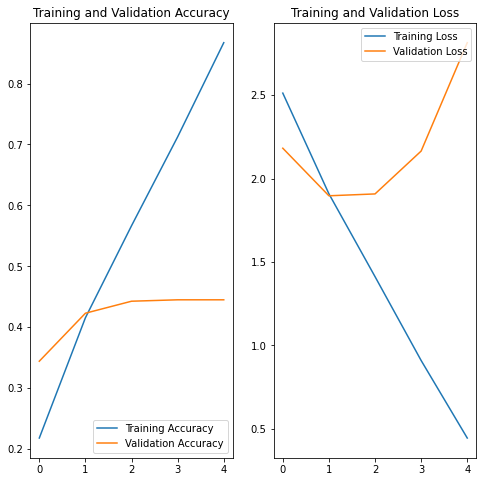

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Making predictions

In [17]:
test_df = pd.read_csv("../plantbase/data/test_data.csv").drop(columns = "Unnamed: 0")

In [20]:
test_df = test_df[['id', 'genus']]
test_df.head()

,id,genus
0,100035,Verbascum
1,100058,Trifolium
2,100186,Veronica
3,100238,Campanula
4,1003,Geranium


In [31]:
test_df.shape

(1341, 2)

In [34]:
test_df[test_df['id'] == 62]

,id,genus
844,62,Trifolium


In [39]:
columns = np.sort(test_df.genus.unique())
columns

array(['Ajuga', 'Allium', 'Campanula', 'Cirsium', 'Crataegus', 'Gentiana',
       'Geranium', 'Iris', 'Malva', 'Narcissus', 'Ophrys', 'Rosa',
       'Trifolium', 'Verbascum', 'Veronica', 'Viola'], dtype=object)

In [40]:
rename_columns = {}
col_index = 0
for n in columns:
    rename_columns[col_index] = n
    col_index += 1
    
rename_columns

{0: 'Ajuga',
 1: 'Allium',
 2: 'Campanula',
 3: 'Cirsium',
 4: 'Crataegus',
 5: 'Gentiana',
 6: 'Geranium',
 7: 'Iris',
 8: 'Malva',
 9: 'Narcissus',
 10: 'Ophrys',
 11: 'Rosa',
 12: 'Trifolium',
 13: 'Verbascum',
 14: 'Veronica',
 15: 'Viola'}

#### loading test images using tensorflow load_img and img_to_array

In [45]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [86]:
X_list = []
y_list = []

for index, row in test_df.iterrows():
    img = load_img(rf"../raw_data/test/{row.id}.jpg", target_size=(256, 256))
    img = tensorflow.keras.preprocessing.image.img_to_array(img)
    #img = tensorflow.expand_dims(img, 0)
    X_list.append(img)
    y_list.append((row.genus, row.id))

In [92]:
test_df[test_df['id'] == 100238]

,id,genus
3,100238,Campanula


In [93]:
y_true_df = pd.DataFrame(y_list, columns = ['true_genus', 'id'])
y_true_df.head()

,true_genus,id
0,Verbascum,100035
1,Trifolium,100058
2,Veronica,100186
3,Campanula,100238
4,Geranium,1003


In [70]:
X_test = np.stack(X_list, axis=0)

In [35]:
# tst_img = tensorflow.keras.preprocessing.image.load_img(
#     rf"../raw_data/test/62.jpg", target_size=(256, 256))

# tst_img_array = tensorflow.keras.preprocessing.image.img_to_array(tst_img)
# tst_img_array = tensorflow.expand_dims(tst_img_array, 0)

In [61]:
y_pred = model.predict(X_test)

In [62]:
y_pred.shape

(1341, 16)

In [63]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.rename(columns = rename_columns)
y_pred_df.head()

,Ajuga,Allium,Campanula,Cirsium,Crataegus,Gentiana,Geranium,Iris,Malva,Narcissus,Ophrys,Rosa,Trifolium,Verbascum,Veronica,Viola
0,0.009051,-18.386015,4.732377,-1.479293,-20.122911,14.957055,-1.388551,13.657499,-2.848875,-0.463963,10.682424,3.318369,9.676308,18.248980,-4.056528,9.465404
1,5.272173,-7.399237,11.201482,-2.387899,-5.906970,7.460537,1.159811,11.351397,-0.926998,-2.527988,0.997939,-5.123841,4.509001,-0.705844,3.324313,9.325556
2,3.603346,-3.651988,5.518752,-2.048735,-6.512932,5.296878,-0.141126,4.933121,-0.441352,-5.655932,-0.542382,-3.705158,-2.033828,1.297081,4.768712,1.713816
3,5.538055,-9.559824,12.601484,9.612250,-8.056983,9.519684,-4.663423,19.036585,0.071390,-8.244115,5.654346,8.344577,2.846742,-1.177238,4.132110,1.189789
4,-1.303522,3.406743,7.891887,-4.901036,0.734513,-3.214595,8.726109,1.500207,2.259264,-10.316482,-2.344843,-3.694071,1.053827,-5.112030,3.826326,3.787920


In [66]:
y_list

[array([[[ 59.,  45.,   8.],
         [ 67.,  59.,  13.],
         [ 70.,  69.,  12.],
         ...,
         [ 71.,  92.,  23.],
         [ 68.,  94.,  21.],
         [ 75., 102.,  25.]],
 
        [[ 79.,  68.,  14.],
         [ 83.,  77.,  17.],
         [ 80.,  79.,  14.],
         ...,
         [ 73.,  95.,  23.],
         [ 71.,  94.,  22.],
         [ 76., 100.,  24.]],
 
        [[100.,  90.,  21.],
         [ 99.,  91.,  19.],
         [ 91.,  87.,  16.],
         ...,
         [ 78., 100.,  28.],
         [ 78., 101.,  29.],
         [ 79., 101.,  28.]],
 
        ...,
 
        [[209., 187., 166.],
         [215., 188., 167.],
         [216., 190., 167.],
         ...,
         [ 99.,  83.,  34.],
         [ 99.,  82.,  38.],
         [100.,  88.,  38.]],
 
        [[211., 186., 166.],
         [213., 185., 164.],
         [213., 185., 163.],
         ...,
         [ 99.,  83.,  34.],
         [ 97.,  80.,  37.],
         [ 96.,  84.,  36.]],
 
        [[210., 185., 163.],
 

In [67]:
y_true = np.stack(y_list, axis = 0)

In [64]:
y_pred_df['pred_genus'] = y_pred_df.idxmax(axis = 1)
y_pred_df['pred_genus']

0       Verbascum
1            Iris
2       Campanula
3            Iris
4        Geranium
5          Ophrys
6          Ophrys
7            Iris
8          Ophrys
9        Geranium
10      Narcissus
11       Geranium
12           Iris
13      Campanula
14      Trifolium
15         Ophrys
16      Campanula
17        Cirsium
18         Ophrys
19      Campanula
20      Campanula
21      Campanula
22           Iris
23           Iris
24           Iris
25         Ophrys
26      Verbascum
27       Geranium
28           Iris
29           Iris
          ...    
1311        Ajuga
1312       Ophrys
1313     Veronica
1314         Iris
1315       Allium
1316       Allium
1317    Campanula
1318       Ophrys
1319    Campanula
1320       Ophrys
1321    Campanula
1322    Campanula
1323     Gentiana
1324        Ajuga
1325        Malva
1326    Campanula
1327     Geranium
1328         Rosa
1329        Viola
1330         Iris
1331         Rosa
1332       Ophrys
1333       Ophrys
1334       Ophrys
1335      

In [95]:
prediction_review = (y_pred_df['pred_genus'] == y_true_df['true_genus'])

In [96]:
prediction_review.count()

1341

In [98]:
prediction_vec_df = y_pred_df[['pred_genus']].copy()
prediction_vec_df['true_genus'] = y_true_df['true_genus'].copy()
prediction_vec_df['result'] = (y_pred_df['pred_genus'] == y_true_df['true_genus'])

In [99]:
prediction_vec_df['false'] = prediction_vec_df['result'].apply(lambda x: 1 if x == False else 0)
prediction_vec_df['true'] = prediction_vec_df['result'].apply(lambda x: 1 if x == True else 0)
prediction_vec_df.head(2)

,pred_genus,true_genus,result,false,true
0,Verbascum,Verbascum,True,0,1
1,Iris,Trifolium,False,1,0


In [101]:
true_pos_neg = prediction_vec_df.groupby('true_genus').sum().drop(columns=['result'])
true_pos_neg['percent_true'] = true_pos_neg['true'] / (true_pos_neg['true'] + true_pos_neg['false'])

In [102]:
success_ratio = round(true_pos_neg[['percent_true']]*100).sort_values(by='percent_true', ascending=False)

In [103]:
success_ratio

,percent_true
true_genus,
Ophrys,72.0
Verbascum,57.0
Cirsium,56.0
Campanula,52.0
Iris,49.0
Gentiana,45.0
Geranium,41.0
Rosa,38.0
Narcissus,30.0


#### loading test images as a tensorflow dataset